## Use image output to numpy array and display it inline

This example shows how to use callback function to read the raytracing output from PlotOptiX on each frame and update image displayed with another package.

It is useul e.g. to show promptly the first frame and update it as the progressive raytracing is accumulating more frames, so we also show how to setup the accumulation parameters.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt # no PlotOptiX UI here, let's use "something else" to display the output

import numpy as np
from plotoptix import NpOptiX

<IPython.core.display.Javascript object>


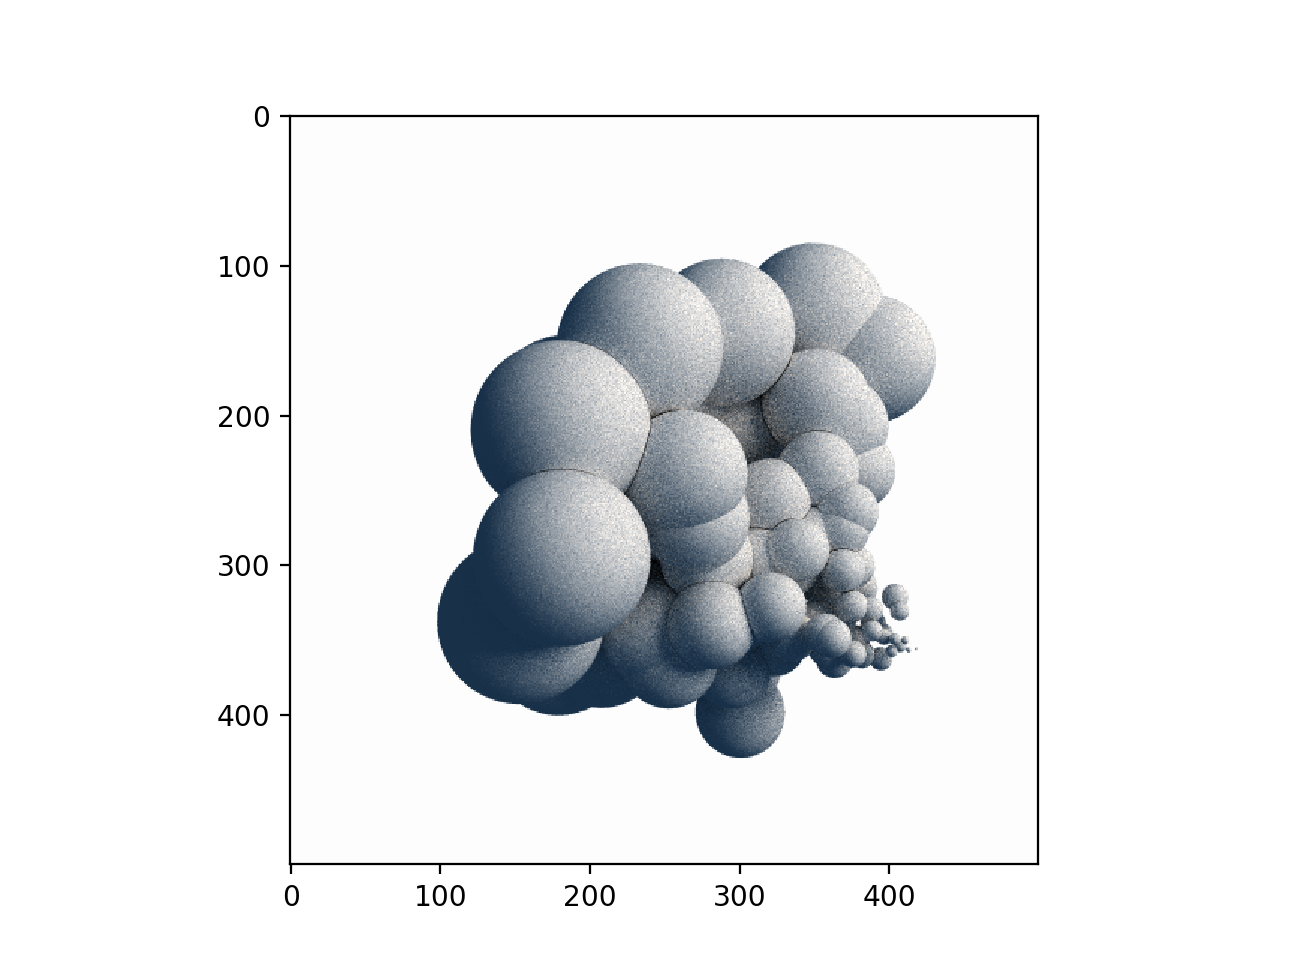

In [2]:
# square 500x500 pixels
width = height = 500

# start with an empty image, use our target size and format: width x height, RGBA 8 bit/channel
# note: the array shape starts with the height dimension
imgplot = plt.imshow(np.zeros((height, width, 4), dtype=np.uint8))

In [3]:
def update_image(rt: NpOptiX) -> None:
    imgplot.set_data(rt._img_rgba) # safe to read the image directly, it is locked during on_launch_finished callback;
    plt.draw()                     # outside callback, use wnd.get_rt_output() to get a copy of the image array

In [4]:
# Use on_rt_accum_done callback to update image after all accumulation is completed (may take a while). This callback
# is also convenient place to run code on a completed image only, e.g. save it to file.
#optix = NpOptiX(on_rt_accum_done=update_image, width=width, height=height, start_now=False)

# Use on_rt_completed callback to update image after each accumulation step.
optix = NpOptiX(on_launch_finished=update_image, width=width, height=height, start_now=False)

optix.set_param(
    min_accumulation_step=4,    # no. of frames computed in an atomic step of raytracing (default is 1 frame)
    max_accumulation_frames=30  # no. of all frames to compute (default is 4 frames)
)

optix.set_background(0.99)                   # white background
optix.set_ambient([0.1, 0.2, 0.3])           # dim bluish ambient light
optix.setup_camera("cam1", eye=[5, -5, -7])  # setup our camera to start with a nice angle
optix.setup_light("light1", color=3*np.array([0.9, 0.8, 0.7]), radius=5) # warm light, default position fits current camera

In [5]:
n = 100
xyz = np.random.random((n, 3))
r = np.random.random(n) + 0.01
for i in range(n): xyz[i] = r[i] * xyz[i] / np.linalg.norm(xyz[i])
    
optix.set_data("plot", pos=xyz, r=0.2*r)     # create plot geometry, particles (spheres) are default
optix.camera_fit(scale=2)                    # move camera to cover all data in view (scale allows distance adjustments)
optix.start()                                # and start raytracing - image appears in the matplotlib figure

30 accumulaton frames are used. Configuration of lights and diffuse material results with a noisy image in this example. More frames are needed, or a denoiser.

In [6]:
plt.xlim(200, 320) # Zoom in on a small section, so we can better appreciate accumulation progress.
plt.ylim(200, 320)

(200, 320)

Increase the number of accumulation frames.

In [7]:
optix.set_param(max_accumulation_frames=1000) # Run the cell and scroll to the figure - image is updated there live.

Or, use AI denoiser to improve image quality before accumulation converges.

In [8]:
optix.set_param(max_accumulation_frames=100) # Go back to a lower number of accumulation frames

optix.set_float("denoiser_blend", 0.1) # Change blend for differet mixing with the raw image. Higher value blends in
optix.add_postproc("Denoiser")         # more of the raw input image. Range is 0.0 to 1.0.

Close the raytracing instance and release all resources.

In [9]:
optix.close()